# [E-11] 폐렴을 진단해보자

## 1. 시작하기전,,

In [95]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [96]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 가져오기

In [52]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train은 5216개, test는 624개, validation은 16개가 있다.  
val 데이터가 너무 적기 때문에 train과 val 데이터를 합친후에 8:2 비율로 다시 나눠준다.

In [53]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [54]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0582-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person313_bacteria_1457.jpeg


In [55]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [56]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [57]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [58]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [59]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [60]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [61]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [62]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [63]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화

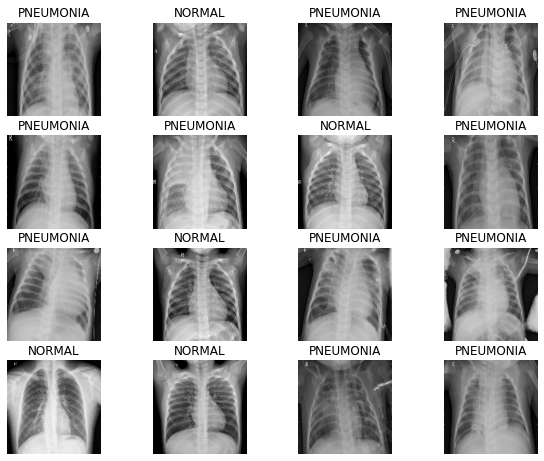

In [64]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링

In [65]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [66]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [67]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalnce 처리

In [68]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련

In [69]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [70]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 42s 134ms/step - loss: 0.5291 - accuracy: 0.7248 - precision: 0.9122 - recall: 0.6995 - val_loss: 0.6540 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 132ms/step - loss: 0.2546 - accuracy: 0.9021 - precision: 0.9694 - recall: 0.8969 - val_loss: 1.1211 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1843 - accuracy: 0.9290 - precision: 0.9808 - recall: 0.9231 - val_loss: 0.6211 - val_accuracy: 0.7548 - val_precision: 0.7495 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 34s 132ms/step - loss: 0.1719 - accuracy: 0.9299 - precision: 0.9801 - recall: 0.9251 - val_loss: 0.1967 - val_accuracy: 0.9240 - val_precision: 0.9914 - val_recall: 0.9042
Epoch 5/25
261/261 [==============================] - 34s 132ms/step - loss: 0.1689 - accura

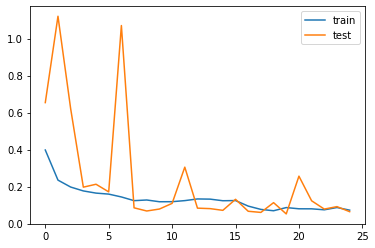

In [71]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [72]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 74ms/step - loss: 0.7139 - accuracy: 0.8654 - precision: 0.8355 - recall: 0.9769
Loss: 0.7139142155647278,
Accuracy: 0.8653846383094788,
Precision: 0.8355262875556946,
Recall: 0.9769230484962463


아무것도 안하고 그냥 두번정도 돌려봤는데 Accuracy가 86%가 넘었다,, 운이 좋은건가,,

---
## try 1 : Early Stop 추가

In [29]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
with tf.device('/GPU:0'):
    es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        callbacks=[es],
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 42s 134ms/step - loss: 0.4582 - accuracy: 0.7721 - precision: 0.9354 - recall: 0.7465 - val_loss: 0.6586 - val_accuracy: 0.7394 - val_precision: 0.7394 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 132ms/step - loss: 0.2441 - accuracy: 0.9073 - precision: 0.9713 - recall: 0.9030 - val_loss: 1.3210 - val_accuracy: 0.7394 - val_precision: 0.7394 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 132ms/step - loss: 0.1796 - accuracy: 0.9382 - precision: 0.9799 - recall: 0.9361 - val_loss: 0.1176 - val_accuracy: 0.9692 - val_precision: 0.9817 - val_recall: 0.9766
Epoch 4/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1912 - accuracy: 0.9315 - precision: 0.9773 - recall: 0.9296 - val_loss: 0.0839 - val_accuracy: 0.9683 - val_precision: 0.9881 - val_recall: 0.9688
Epoch 5/25
261/261 [==============================] - 34s 132ms/step - loss: 0.1587 - accura

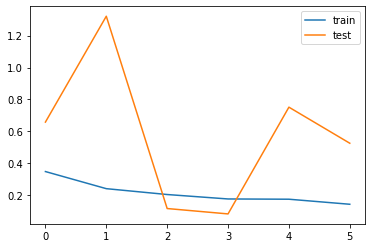

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [32]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 74ms/step - loss: 0.4522 - accuracy: 0.8686 - precision: 0.9208 - recall: 0.8641
Loss: 0.45218849182128906,
Accuracy: 0.8685897588729858,
Precision: 0.9207650423049927,
Recall: 0.8641025424003601


early stopp을 추가하니 5에폭만에 학습이 멈췄다.  
결과를 봤을땐 Acc는 조금 올라갔지만, recall이 많이 떨어졌다.  
병을 진단하는 모델은 recall이 높아야하는데 좋은 결과라고 볼 수 없다.  

## try 2 : Batch Size 조절

위에 초반 모델을 보니 overfit된 것 같아서 batch_size를 줄여서 다시 학습을 시켜보자

In [74]:
BATCH_SIZE = 8

In [75]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [76]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [77]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [78]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [79]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [80]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
523/523 [==============================] - 72s 76ms/step - loss: 0.6046 - accuracy: 0.6923 - precision: 0.9014 - recall: 0.6628 - val_loss: 1.0942 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
523/523 [==============================] - 39s 74ms/step - loss: 0.3568 - accuracy: 0.8488 - precision: 0.9521 - recall: 0.8382 - val_loss: 0.3263 - val_accuracy: 0.8779 - val_precision: 0.8619 - val_recall: 0.9921
Epoch 3/25
523/523 [==============================] - 38s 73ms/step - loss: 0.2694 - accuracy: 0.8860 - precision: 0.9712 - recall: 0.8733 - val_loss: 0.3659 - val_accuracy: 0.8567 - val_precision: 1.0000 - val_recall: 0.8050
Epoch 4/25
523/523 [==============================] - 39s 74ms/step - loss: 0.2487 - accuracy: 0.9001 - precision: 0.9732 - recall: 0.8904 - val_loss: 0.1487 - val_accuracy: 0.9462 - val_precision: 0.9480 - val_recall: 0.9803
Epoch 5/25
523/523 [==============================] - 39s 74ms/step - loss: 0.2491 - accuracy: 0

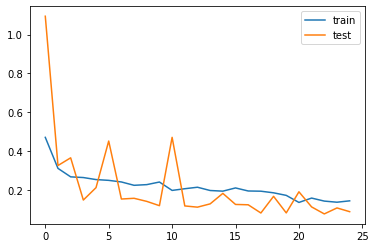

In [81]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [82]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 3s 37ms/step - loss: 0.9918 - accuracy: 0.8397 - precision: 0.8072 - recall: 0.9769
Loss: 0.991815447807312,
Accuracy: 0.8397436141967773,
Precision: 0.8072034120559692,
Recall: 0.9769230484962463


ACC가 오히려 더 떨어졌다. 대산 loss가 올라갔고 recall은 그대로이다..(어떻게 똑같이 나왔지)

## try 3 : Data Argument

In [83]:
BATCH_SIZE = 16
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

Image shape:  (180, 180, 3)
Label:  False


In [84]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [85]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [86]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [90]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 39s 130ms/step - loss: 0.1697 - accuracy: 0.9370 - precision: 0.9827 - recall: 0.9318 - val_loss: 1.2906 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 130ms/step - loss: 0.1698 - accuracy: 0.9344 - precision: 0.9781 - recall: 0.9328 - val_loss: 0.1099 - val_accuracy: 0.9587 - val_precision: 0.9510 - val_recall: 0.9947
Epoch 3/25
261/261 [==============================] - 34s 130ms/step - loss: 0.1715 - accuracy: 0.9368 - precision: 0.9788 - recall: 0.9354 - val_loss: 1.2954 - val_accuracy: 0.5644 - val_precision: 1.0000 - val_recall: 0.4063
Epoch 4/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1476 - accuracy: 0.9447 - precision: 0.9855 - recall: 0.9395 - val_loss: 0.2073 - val_accuracy: 0.9192 - val_precision: 0.9985 - val_recall: 0.8914
Epoch 5/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1470 - accura

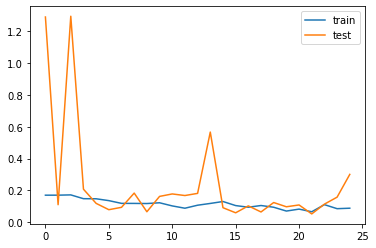

In [91]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [92]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 75ms/step - loss: 1.9557 - accuracy: 0.7740 - precision: 0.7456 - recall: 0.9692
Loss: 1.9556500911712646,
Accuracy: 0.7740384340286255,
Precision: 0.7455621361732483,
Recall: 0.9692307710647583


증강데이터를 추가했더니 오히려 더 떨어졌다.. 

## Try4 : Data Argument & 16 epochs

In [103]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [104]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=16,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/16
261/261 [==============================] - 42s 135ms/step - loss: 0.6246 - accuracy: 0.6958 - precision: 0.8954 - recall: 0.6705 - val_loss: 0.6534 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/16
261/261 [==============================] - 34s 130ms/step - loss: 0.2757 - accuracy: 0.8899 - precision: 0.9721 - recall: 0.8773 - val_loss: 1.0815 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/16
261/261 [==============================] - 34s 130ms/step - loss: 0.2146 - accuracy: 0.9200 - precision: 0.9764 - recall: 0.9152 - val_loss: 0.6292 - val_accuracy: 0.7471 - val_precision: 0.7434 - val_recall: 1.0000
Epoch 4/16
261/261 [==============================] - 34s 130ms/step - loss: 0.1985 - accuracy: 0.9286 - precision: 0.9716 - recall: 0.9300 - val_loss: 0.2071 - val_accuracy: 0.9087 - val_precision: 0.8901 - val_recall: 0.9987
Epoch 5/16
261/261 [==============================] - 34s 131ms/step - loss: 0.1646 - accura

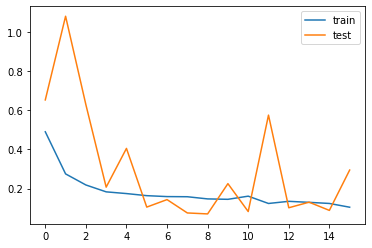

In [105]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [106]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 72ms/step - loss: 0.3181 - accuracy: 0.8814 - precision: 0.8970 - recall: 0.9154
Loss: 0.3180559277534485,
Accuracy: 0.8814102411270142,
Precision: 0.8969849348068237,
Recall: 0.9153845906257629


# 회고

## Loss 그래프 비교

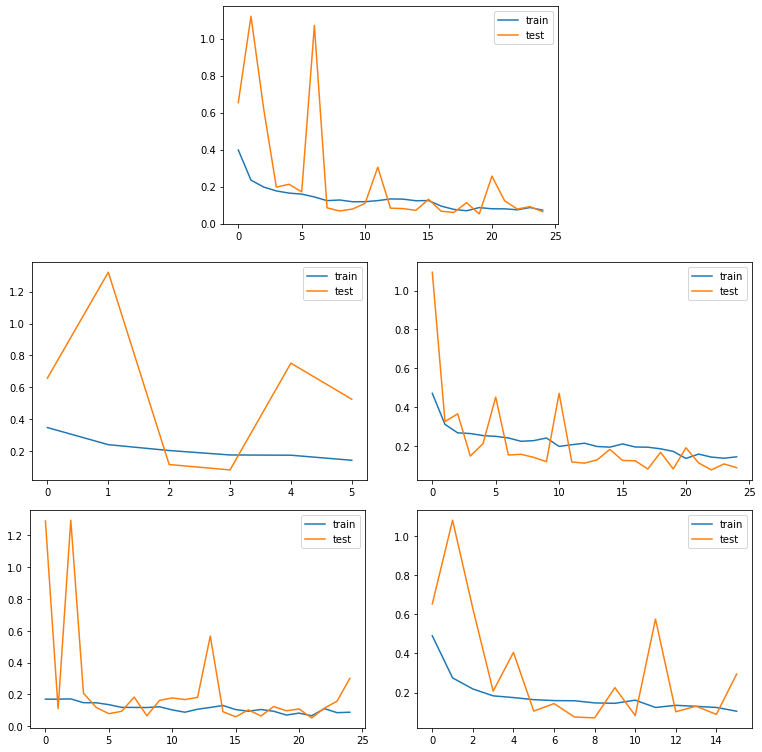

순서대로 기존 모델 , try1(earlystop), try2(batch_size=8), try3(데이터 증강), try4(데이터 증강+에폭 조절)의 각각 loss 그래프다.  

## 성능 평가 비교

||loss|accuracy|precision|recall|
|---|---|---|---|---|
|기존|0.7139|0.8653|0.8355|0.9769|
|Try1|0.4521|0.8685|0.9207|0.8641|
|Try2|0.9918|0.8397|0.8072|0.9769|
|Try3|1.9556|0.7740|0.7455|0.9692|
|Try4|0.3180|0.8814|0.8969|0.9154|


그래프와 정확도를 봤을때 가장 좋은 성능을 보이는 것은 Try 4이다.  
그러나 환자를 환자가 아니라고 판단하면 안됨으로 recall이 가장 높아야한다.  
그래서 기존의 모델이 가장 좋은 것 같다!!